# **Distinguishing AI-Generated and Human-Written Essays**

This project aims to classify AI-generated and human-written essays.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import nltk
import re
from nltk.tokenize import sent_tokenize
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from collections import Counter
# Models
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.svm import SVC # SVM
import xgboost as xgb # XGBoost

In [2]:
nltk.download('stopwords')
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download('wordnet')
!pip install textblob
nltk.download('textblob')
!pip install xgboost

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Error loading textblob: Package 'textblob' not found in
[nltk_data]     index


In [3]:
"""
Explanation from original source:
Around 500K essays are available in this dataset, both created by AI and written by Human.
Gathered from multiple sources, added them together and removed the duplicates
Source: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data
"""

df1 = pd.DataFrame()

# There was a problem with reading the file, that is why I created a while loop to read the file until it has reached a certain observation count.
# This still could create reproducibility problems, and should be adressed with a certain solution.
while df1.shape[0] < 487_235:
    df1 = pd.read_csv("AI_Human.csv", engine='python', on_bad_lines='skip')  # 0-Human, 1-Machine
    # df = pd.read_csv("AI_Human.csv", dtype=str, on_bad_lines='skip')
    print(f"Rows read: {df1.shape[0]}")

# Observation and column count
df1.shape

Rows read: 487235


(487235, 2)

In [4]:
df1

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


In [5]:
# Count for each class of generated column - 0 and 1.
df1['generated'].value_counts()

,count
generated,
0.0,305797
1.0,181438


# Word Count Distribuiton

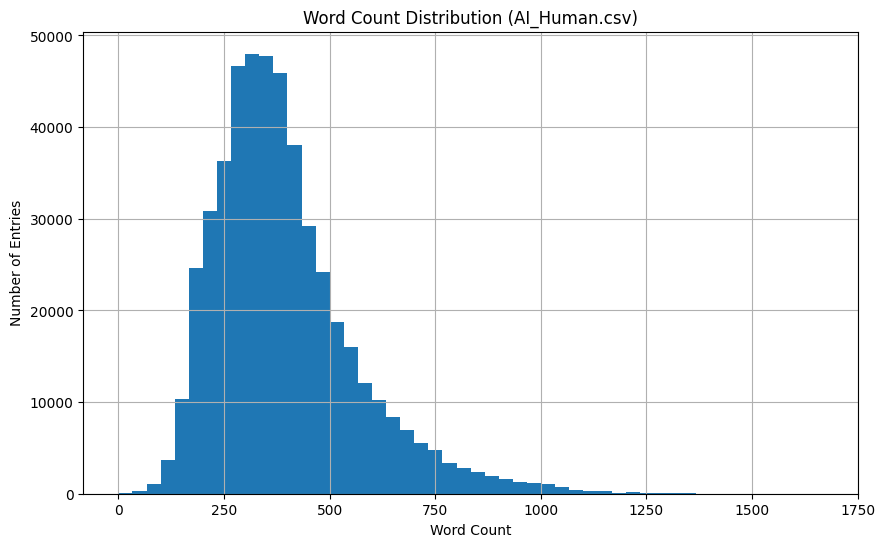

In [6]:
# Calculate word count for each text entry
df1['word_count'] = df1['text'].astype(str).apply(lambda x: len(x.split()))

# Visualize the word count distribution
plt.figure(figsize=(10, 6))
df1['word_count'].hist(bins=50)
plt.title("Word Count Distribution (AI_Human.csv)")
plt.xlabel("Word Count")
plt.ylabel("Number of Entries")
plt.grid(True)
plt.show()

#**1. Text Preprocessing**

In [7]:
# Filter texts with 200-500 words
filtered_df = df1[(df1['word_count'] >= 200) & (df1['word_count'] <= 500)]
filtered_df['generated'].value_counts()

,count
generated,
0.0,197395
1.0,150254


In [8]:
# To make sure there are enough observations for each class
class_counts = filtered_df['generated'].value_counts()

# Randomly select 2500 samples from each class
if class_counts[0] >= 2500 and class_counts[1] >= 2400:
  sampled_0 = filtered_df[filtered_df['generated'] == 0].sample(n=5000, random_state=42)
  sampled_1 = filtered_df[filtered_df['generated'] == 1].sample(n=4900, random_state=42) # I will include the remaining 100 from the dataset I prepared.
else:
    print("❗ Not enough samples in filtered_df!")
    print(class_counts)

# Combine the samples
balanced_df = pd.concat([sampled_0, sampled_1], ignore_index=True)
balanced_df

,text,generated,word_count
0,"Uear Principal,\n\nMy opinion is that we stude...",0.0,201
1,Let me clear something up for you. The picture...,0.0,277
2,"School is a sacred place for learning, making ...",0.0,455
3,Have you ever UAD to do summer projects during...,0.0,410
4,"Dear. Mr. President,\n\nI feel that we should ...",0.0,321
...,...,...,...
9895,Have you ever seen the surface of MaRs and it...,1.0,293
9896,"Sure, here's my attempt at writing an essay as...",1.0,373
9897,Title: The Pros and Cons of Car-free Cities\n\...,1.0,466
9898,"In today's society, it is essential to have TH...",1.0,391


In [9]:
"""
Explanation: This dataset includes 100 texts I generated using ChatGPT 4o model.
"""
df2 = pd.read_excel("ChatGPT_Text_100.xlsx")
df2.head()

,ID,Prompt,Parameters,Title,ChatGPT_generated_text
0,1,write some academic writings in different subj...,"200 words, academic writing",Psychology – The Role of Cognitive Biases in D...,Cognitive biases are systematic patterns of de...
1,2,write some academic writings in different subj...,NaN,Computer Science – The Importance of Algorithm...,Algorithm optimization is a fundamental aspect...
2,3,write some academic writings in different subj...,NaN,Economics – The Impact of Inflation on Purchas...,Inflation is defined as the general increase i...
3,4,write some academic writings in different subj...,NaN,Environmental Science – The Role of Renewable ...,"Renewable energy sources, such as solar, wind,..."
4,5,write some academic writings in different subj...,NaN,Education – The Role of Technology in Modern C...,The integration of technology into education h...


In [10]:
df2.shape

(100, 5)

In [11]:
# Combining Title and Text
df2['text'] = df2['Title'] + '. ' + df2['ChatGPT_generated_text'].str.replace('\n', ' ')
df2_clean = df2[['text']].copy()
df2_clean['generated'] = 1

# Calculating word count for each text entry
df2_clean['word_count'] = df2_clean['text'].astype(str).apply(lambda x: len(x.split()))

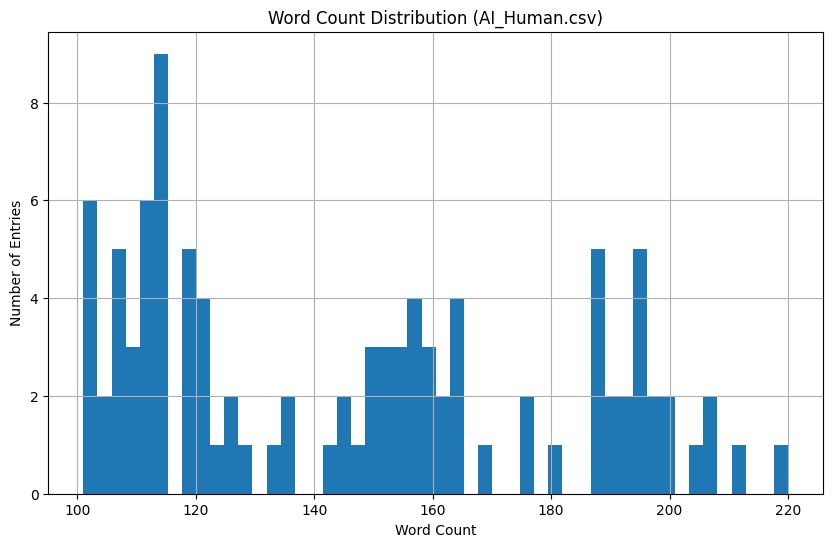

In [12]:
# Visualize the word count distribution
plt.figure(figsize=(10, 6))
df2_clean['word_count'].hist(bins=50)
plt.title("Word Count Distribution (AI_Human.csv)")
plt.xlabel("Word Count")
plt.ylabel("Number of Entries")
plt.grid(True)
plt.show()

In [13]:
# Combining two datasets
df = pd.concat([balanced_df, df2_clean], ignore_index=True)
df

,text,generated,word_count
0,"Uear Principal,\n\nMy opinion is that we stude...",0.0,201
1,Let me clear something up for you. The picture...,0.0,277
2,"School is a sacred place for learning, making ...",0.0,455
3,Have you ever UAD to do summer projects during...,0.0,410
4,"Dear. Mr. President,\n\nI feel that we should ...",0.0,321
...,...,...,...
9995,Fashion Studies – Fast Fashion and Ethical Con...,1.0,103
9996,Music – The Psychology of Music and Emotion. M...,1.0,105
9997,Agricultural Science – Precision Agriculture a...,1.0,109
9998,Game Studies – Serious Games in Education. Ser...,1.0,103


In [14]:
print(df['text'].iloc[1])

Let me clear something up for you. The picture of 1976,1998 and 2001 was not created by aliens. I know that because how would the aliens know how to build an Egyptian pharaoh. Plus the sent to Mars was just taking pictures of a landing site for viking 1's sister viking 2. The first time they saw the face was when it was all shadowy, so you could barely see it but as time past by it was 1998 when they went back up to Mars with OE of the vikings to take another picture, and it was more clear. They had to 12 years to go back up to Mars and I don't think that aliens could build it that fast, it would've at least taken more time to make a good face. Then at the year 2001 they took another picture, and it was fading away and I honestly don't think that the aliens would be able to take the face down that fast and why would they have to take it down. It has to be natural because there are no such things as aliens, because no one from NASA has ever seen one and if they would've NASA would've to

In [15]:
# Work on duplicates - apply cosine similarity and decide on a threshold to remove duplicates. Optional

In [16]:
# Function for preprocessing with optional punctuation removal
def pre_processing(df, remove_punctuation=True):

  # Normalizing case folding
  # All words converted to lowercase to ensure consistency.
  df['text'] = df['text'].str.lower()

  if remove_punctuation:
    # Remove punctuations
    df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
    # Remove numbers and symbols using regex
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
  else:
    # Remove only numbers, not punctuation
    df['text'] = df['text'].str.replace(r'\d', '', regex=True)
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

  # Stopwords
  # Stopword removal is an essential step in text processing, and it focuses on eliminating commonly used words like: I, the, of, my, it, to, and from.
  sw = stopwords.words('english')
  df['text'] = df['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

  # Removing rarewords (optional step)
  temp_df = pd.Series(' '.join(df['text']).split()).value_counts() # Counting words

  drops = temp_df[temp_df <= 1] # Creating a threshold

  df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in drops)) # Removing rare words

  # Lemmatization
  # A grammatical process that converts words to their dictionary form.
  df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  # Note: Tokenization is included within other steps with split() method.

  return df

# Keep punctuation: For average sentence length analysis
df_with_punctuation = pre_processing(df.copy(), remove_punctuation=False)

# Remove punctuation
df = pre_processing(df, remove_punctuation=True)
df

,text,generated,word_count
0,principal opinion student always going b avera...,0.0,201
1,let clear something picture created alien know...,0.0,277
2,school sacred place learning making new friend...,0.0,455
3,ever uad summer project summer break school re...,0.0,410
4,dear mr president feel change electoral collag...,0.0,321
...,...,...,...
9995,fashion study fast fashion ethical consumption...,1.0,103
9996,music psychology music emotion music profoundl...,1.0,105
9997,agricultural science precision agriculture foo...,1.0,109
9998,game study serious game education serious game...,1.0,103


In [17]:
print(df_with_punctuation['text'].iloc[1])

let clear something you. picture , created aliens. know would alien know build egyptian pharaoh. plus sent mar taking picture landing site viking 's sister viking . first time saw face shadowy, could barely see time past went back mar oe viking take another picture, clear. year go back mar think alien could build fast, would've least taken time make good face. year took another picture, fading away honestly think alien would able take face fast would take down. natural thing aliens, one nasa ever seen one would've nasa would've told everybody found alien real. also, know natural even nasa said face nose, eyes,mouth, looked exactly like human face. would alien know human head look like? nasa taking picture head red planet called colonia looking back camera. also, maybe head appears different years.


In [18]:
print(df['text'].iloc[1])

let clear something picture created alien know would alien know build egyptian pharaoh plus sent mar taking picture landing site viking sister viking first time saw face shadowy could barely see time past went back mar oe viking take another picture clear year go back mar dont think alien could build fast wouldve least taken time make good face year took another picture fading away honestly dont think alien would able take face fast would take natural thing alien one nasa ever seen one wouldve nasa wouldve told everybody found alien real also know natural even nasa said face nose eyesmouth looked exactly like human face would alien know human head look like nasa taking picture head red planet called colonia looking back camera also maybe head appears different year


# **2. Text Visualization**

**Term Frequency**

In [19]:
# Calculating Term Frequency
tf = df["text"].apply(lambda x: pd.Series(x.split()).value_counts()).sum(axis=0).reset_index()

tf.columns = ["Words", "Term Frequency"]
tf = tf.sort_values("Term Frequency", ascending=False).reset_index(drop=True)
tf.head()

,Words,Term Frequency
0,student,24934.0
1,car,21079.0
2,people,19937.0
3,would,15231.0
4,also,12534.0


**Bar Chart for Term Frequency**

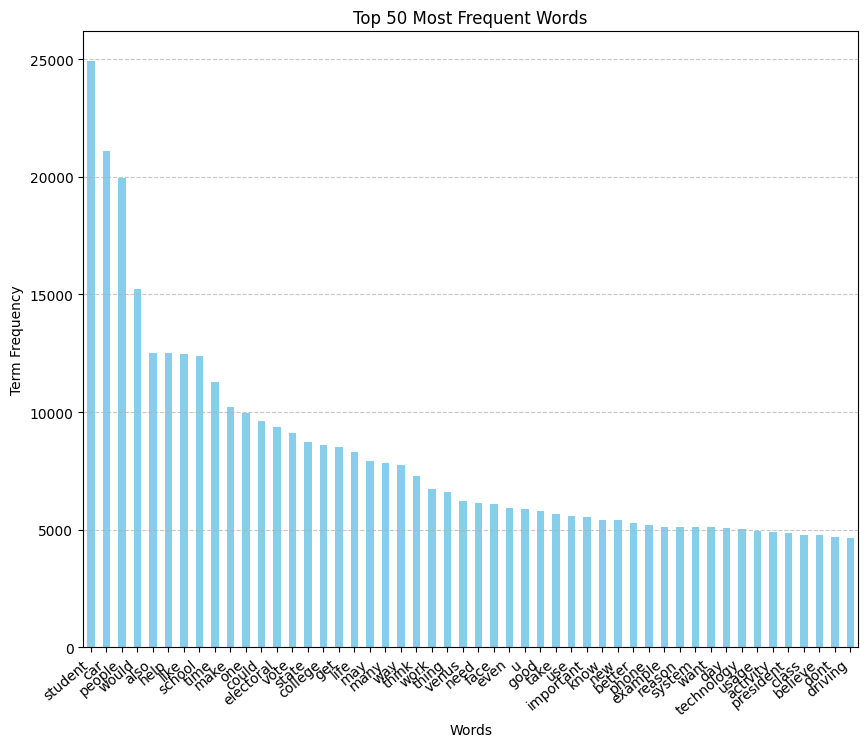

In [20]:
# Top 50 words barplot by frequency
top_words = tf.sort_values(by='Term Frequency', ascending=False).head(50)

# Plot
top_words.plot.bar(x='Words', y='Term Frequency', figsize=(10,8), color='skyblue', legend=False)
plt.xticks(rotation=40, ha='right')
plt.ylabel('Term Frequency')
plt.title('Top 50 Most Frequent Words')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Word cloud**

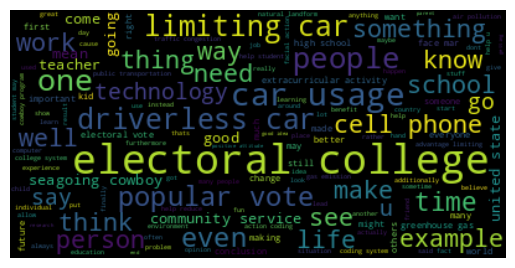

In [21]:
# Wordcloud
text = " ".join(i for i in df.text)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

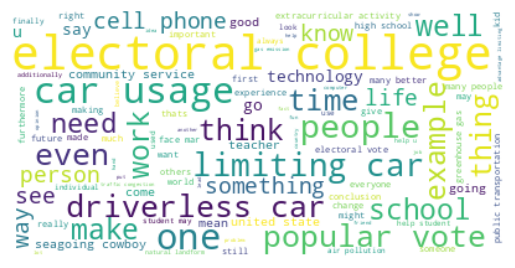

In [22]:
# Wordcloud with max_font_size etc.
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

**Average sentence word count**

Human - Average Sentence Length:
count    5000.000000
mean       11.120251
std         5.338020
min         4.103448
25%         8.500000
50%        10.157895
75%        12.266667
max       104.000000
Name: text, dtype: float64

AI - Average Sentence Length:
count    5000.000000
mean       11.079039
std         2.827564
min         3.977273
25%         9.307692
50%        10.833333
75%        12.500000
max        46.666667
Name: text, dtype: float64


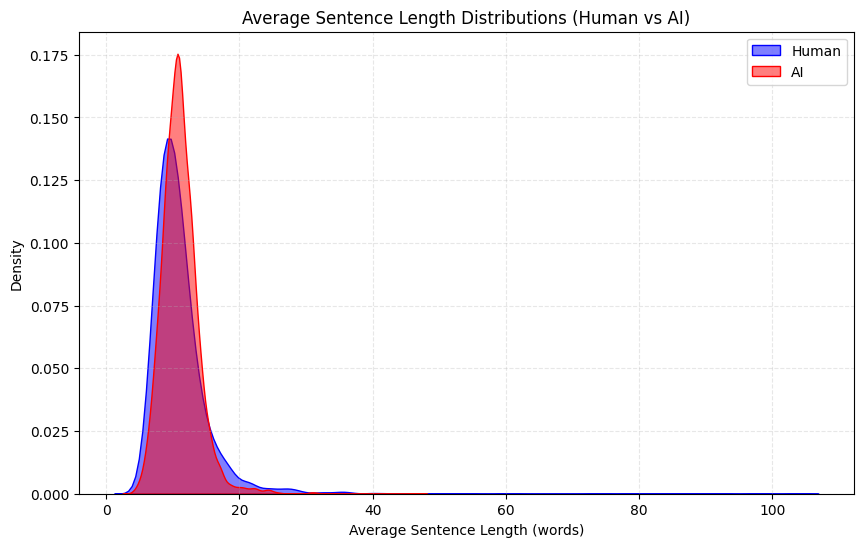

In [23]:
# Function to calculate average sentence length
def avg_sentence_length(text):
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0
    total_words = sum(len(sentence.split()) for sentence in sentences)
    return total_words / len(sentences)

# Calculate for each class separately (Human vs AI)
human_texts = df_with_punctuation[df_with_punctuation['generated'] == 0]['text']
ai_texts = df_with_punctuation[df_with_punctuation['generated'] == 1]['text']

human_avg_lengths = human_texts.apply(avg_sentence_length)
ai_avg_lengths = ai_texts.apply(avg_sentence_length)

# Print basic statistics
print("Human - Average Sentence Length:")
print(human_avg_lengths.describe())
print("\nAI - Average Sentence Length:")
print(ai_avg_lengths.describe())

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(human_avg_lengths, label='Human', fill=True, color='blue', alpha=0.5)
sns.kdeplot(ai_avg_lengths, label='AI', fill=True, color='red', alpha=0.5)
plt.title('Average Sentence Length Distributions (Human vs AI)')
plt.xlabel('Average Sentence Length (words)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

The plots above illustrate the distribution of average sentence length in essays written by humans (blue) and generated by AI (red). While both distributions peak around the 10–15 word range, the AI-generated texts appear to have a more consistent, narrower distribution. This suggests that AI-generated essays tend to have more uniform sentence structures compared to human-written texts, which show a broader range of sentence lengths, including longer and shorter sentences.

In [24]:
# Testing with the first essay to calculate the number of sentences.
# If this is 1, it means there is a problem with the punctuations.
text = df_with_punctuation['text'].iloc[0]
sentences = sent_tokenize(text)
print(f"Number of sentences: {len(sentences)}")

Number of sentences: 8


As we have guessed, there is a problem with the sentences. The problem could be caused by lack of punctuation marks.

**Sentiment Polarity Analysis**

Human - Sentiment Polarity:
count    5000.000000
mean        0.137123
std         0.119187
min        -0.460000
25%         0.059795
50%         0.132360
75%         0.211327
max         0.700000
Name: text, dtype: float64

AI - Sentiment Polarity:
count    5000.000000
mean        0.144917
std         0.097868
min        -0.339923
25%         0.080747
50%         0.138624
75%         0.206268
max         0.540909
Name: text, dtype: float64


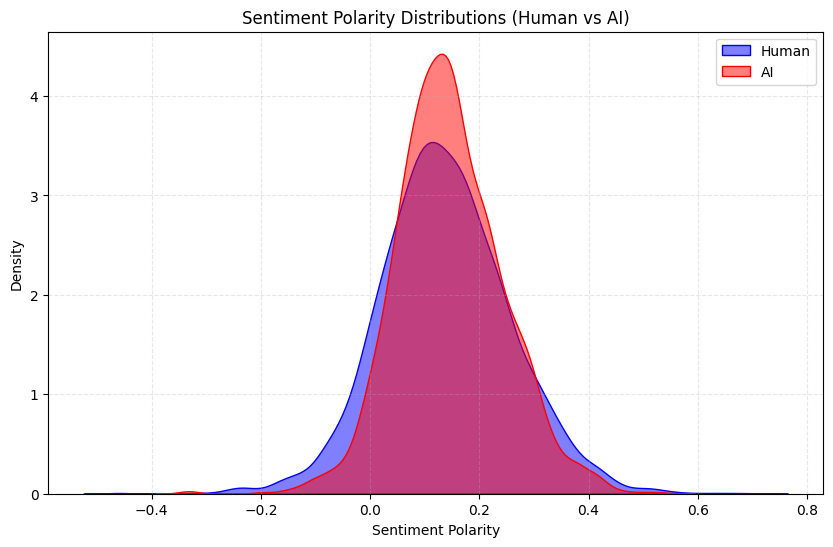

In [25]:
# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Human and AI text subsets
human_texts = df[df['generated']==0]['text']
ai_texts = df[df['generated']==1]['text']

# Calculate sentiment polarity for each text (no new column!)
human_sentiments = human_texts.apply(get_sentiment)
ai_sentiments = ai_texts.apply(get_sentiment)

# Basic statistics
print("Human - Sentiment Polarity:")
print(human_sentiments.describe())
print("\nAI - Sentiment Polarity:")
print(ai_sentiments.describe())

# Plot distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(human_sentiments, label='Human', fill=True, color='blue', alpha=0.5)
sns.kdeplot(ai_sentiments, label='AI', fill=True, color='red', alpha=0.5)
plt.title('Sentiment Polarity Distributions (Human vs AI)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

The sentiment analysis reveals that both human-written and AI-generated texts have an overall slightly positive sentiment tone. However, human texts exhibit a wider range of emotional expressions, with more extreme positive and negative polarity values compared to AI texts. This suggests that while AI-generated essays tend to be consistently mild and neutral in sentiment, human essays are more emotionally diverse and expressive.

# **3. Feature Extraction and Model**

In [26]:
# Preprocessing once

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000) # 5000 most frequent words
X = vectorizer.fit_transform(df['text'])
y = df['generated'] # 0: Human, 1: AI

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **Logistic Regression**

In [27]:
# Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
lr_accuracy = round(accuracy_score(y_test, y_pred), 3)
lr_precision = round(precision_score(y_test, y_pred), 3)
lr_recall = round(recall_score(y_test, y_pred), 3)
lr_f1 = round(f1_score(y_test, y_pred), 3)

# Results
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)

Accuracy: 0.974
Precision: 0.974
Recall: 0.974
F1 Score: 0.974


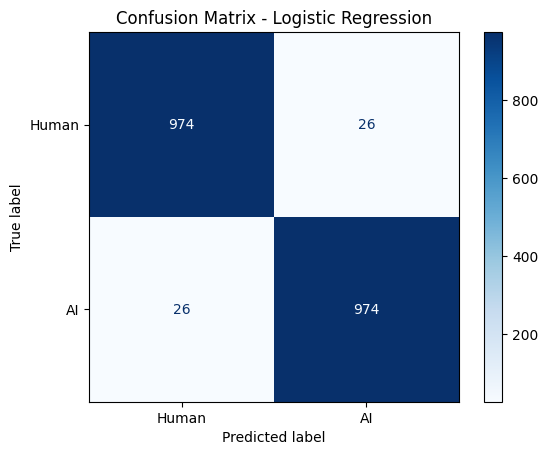

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix'i visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

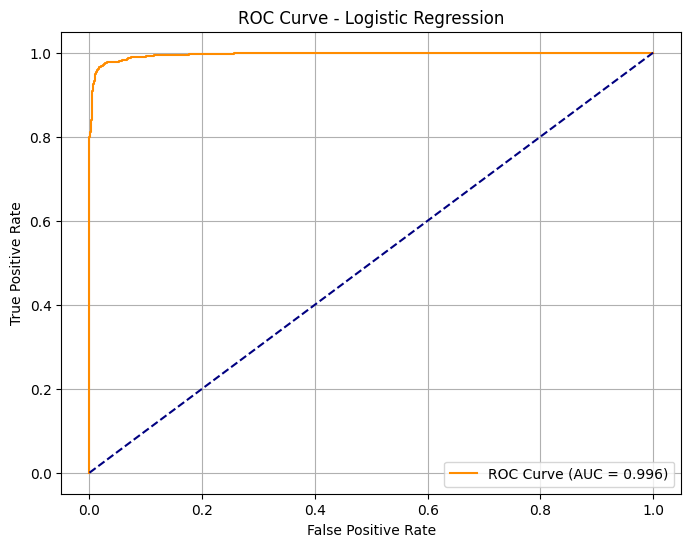

In [29]:
# Get predicted probabilities for the positive class (AI = 1)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
auc_score = round(roc_auc_score(y_test, y_prob), 3)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {auc_score})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal = random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **SVM**

In [30]:
# SVM Model
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred_svm = model.predict(X_test)

# Evaluation
svm_accuracy = round(accuracy_score(y_test, y_pred_svm), 3)
svm_precision = round(precision_score(y_test, y_pred_svm), 3)
svm_recall = round(recall_score(y_test, y_pred_svm), 3)
svm_f1 = round(f1_score(y_test, y_pred_svm), 3)

# Results
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)

Accuracy: 0.983
Precision: 0.988
Recall: 0.978
F1 Score: 0.983


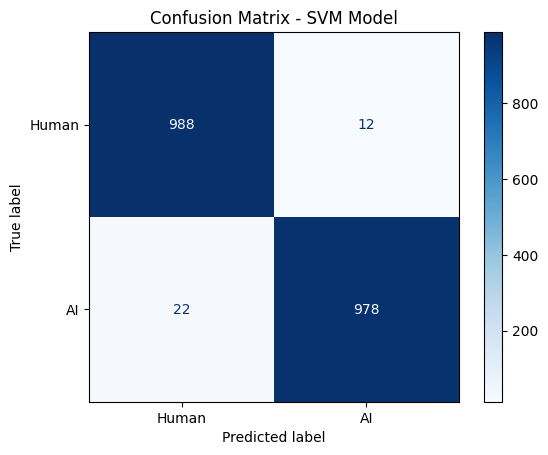

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM Model")
plt.show()

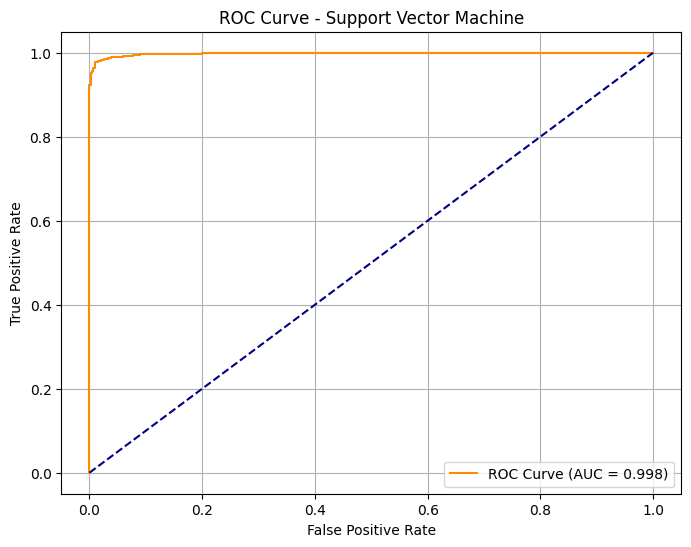

In [32]:
# Get predicted probabilities for the positive class (AI = 1)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = round(roc_auc_score(y_test, y_prob), 3)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {auc_score})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line = random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machine')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **XGBoost**

In [33]:
# XGBoost Model
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test)

# Evaluation
xgboost_accuracy = round(accuracy_score(y_test, y_pred), 3)
xgb_precision = round(precision_score(y_test, y_pred), 3)
xgb_recall = round(recall_score(y_test, y_pred), 3)
xgb_f1 = round(f1_score(y_test, y_pred), 3)

# Results
print("Accuracy:", xgboost_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)

Accuracy: 0.974
Precision: 0.983
Recall: 0.964
F1 Score: 0.973


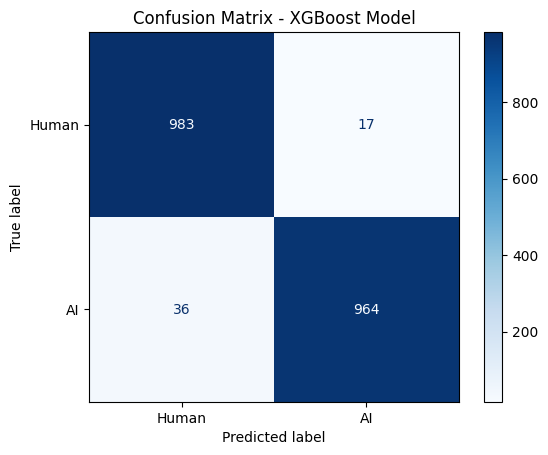

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost Model")
plt.show()

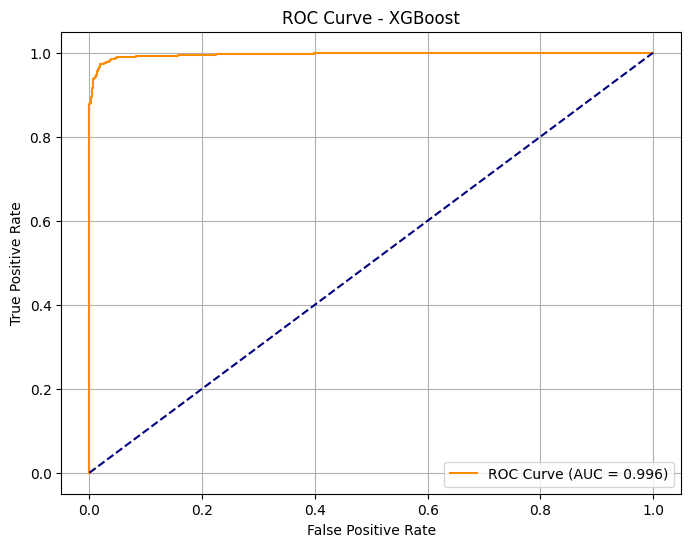

In [35]:
# Get predicted probabilities for the positive class (AI = 1)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = round(roc_auc_score(y_test, y_prob), 3)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {auc_score})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal = random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Decision Tree Classifier**

In [36]:
# Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
dt_y_pred = dt_model.predict(X_test)

# Evaluation
dt_accuracy = round(accuracy_score(y_test, dt_y_pred), 3)
dt_precision = round(precision_score(y_test, dt_y_pred), 3)
dt_recall = round(recall_score(y_test, dt_y_pred), 3)
dt_f1 = round(f1_score(y_test, dt_y_pred), 3)

# Results
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)

Accuracy: 0.895
Precision: 0.89
Recall: 0.901
F1 Score: 0.896


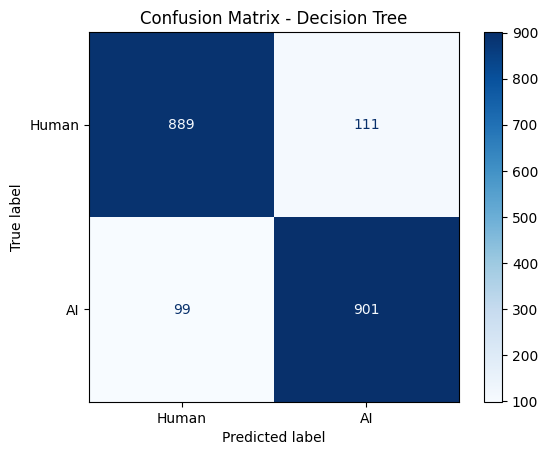

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, dt_y_pred)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'AI'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

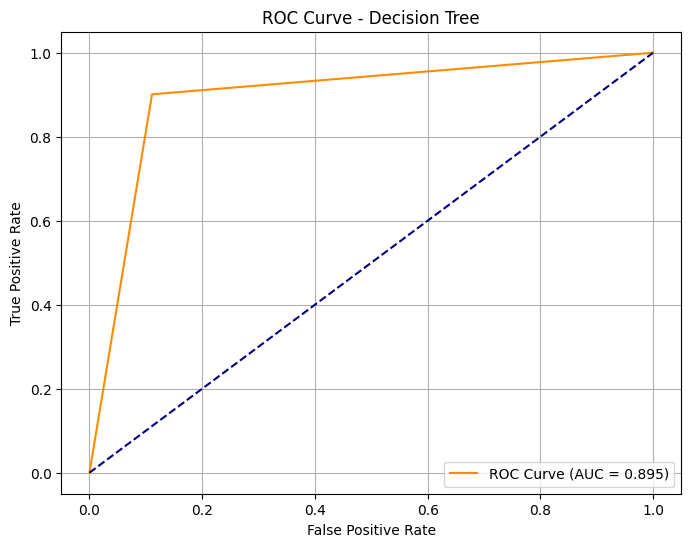

In [38]:
# Get predicted probabilities for the positive class
y_prob = dt_model.predict_proba(X_test)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = round(roc_auc_score(y_test, y_prob), 3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {auc_score})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Random Forest Classifier**

In [39]:
# Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_y_pred = rf_model.predict(X_test)

# Evaluation
rf_accuracy = round(accuracy_score(y_test, rf_y_pred), 3)
rf_precision = round(precision_score(y_test, rf_y_pred), 3)
rf_recall = round(recall_score(y_test, rf_y_pred), 3)
rf_f1 = round(f1_score(y_test, rf_y_pred), 3)

# Results
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

Accuracy: 0.969
Precision: 0.981
Recall: 0.956
F1 Score: 0.968


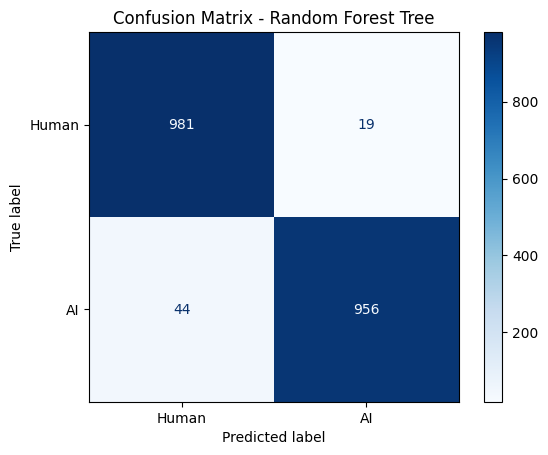

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_y_pred)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'AI'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest Tree")
plt.show()

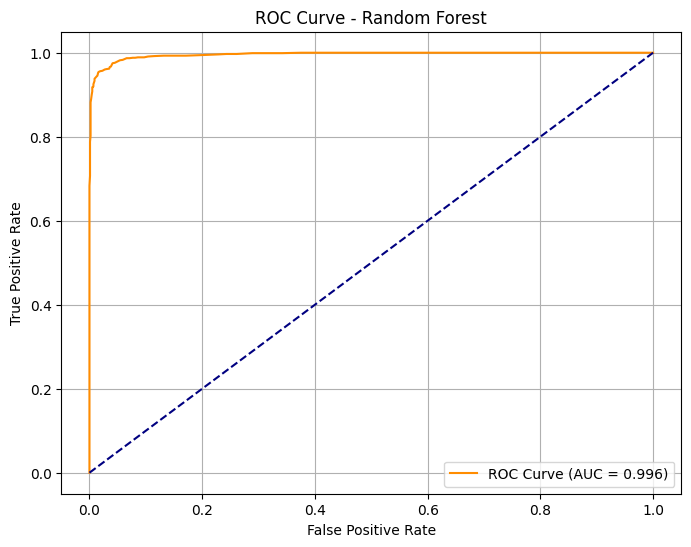

In [41]:
# Get predicted probabilities for the positive class (AI = 1)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = round(roc_auc_score(y_test, y_prob), 3)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {auc_score})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Model Performance Comparison**

In [42]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'XGBoost', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, svm_accuracy, xgboost_accuracy, dt_accuracy, rf_accuracy],
    'Precision': [lr_precision, svm_precision, xgb_precision, dt_precision, rf_precision],
    'Recall': [lr_recall, svm_recall, xgb_recall, dt_recall, rf_recall],
    'F1 Score': [lr_f1, svm_f1, xgb_f1, dt_f1, rf_f1]
})

models

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.974,0.974,0.974,0.974
1,Support Vector Machine,0.983,0.988,0.978,0.983
2,XGBoost,0.974,0.983,0.964,0.973
3,Decision Tree,0.895,0.890,0.901,0.896
4,Random Forest,0.969,0.981,0.956,0.968


The SVM model achieved the highest performance across all evaluation metrics (accuracy, precision, recall, and F1 score). With an accuracy of 0.983, precision of 0.988, recall of 0.978, and an F1 score of 0.983, it consistently outperformed other models.

The superior performance of the SVM model can be attributed to its linear decision boundary, which is particularly well-suited for high-dimensional TF-IDF features. Unlike tree-based methods prone to overfitting and may underperform in fine-grained text separation, SVMs maximize the margin between classes, leading to better generalization and higher F1 scores. These characteristics make SVM especially effective for text classification tasks where subtle differences, such as those between AI-generated and human-written essays, are critical.

# Analyzing the misclassified essays for SVM and comparing with the correctly classified essays

In this section, we will analyze the misclassified essays and try to understand why the model was not able to correctly classify these essays by applying word count analysis and sentiment analysis.

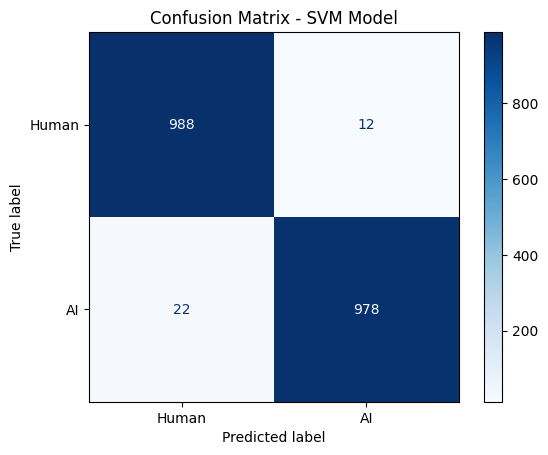

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM Model")
plt.show()

# Word Frequency Analysis

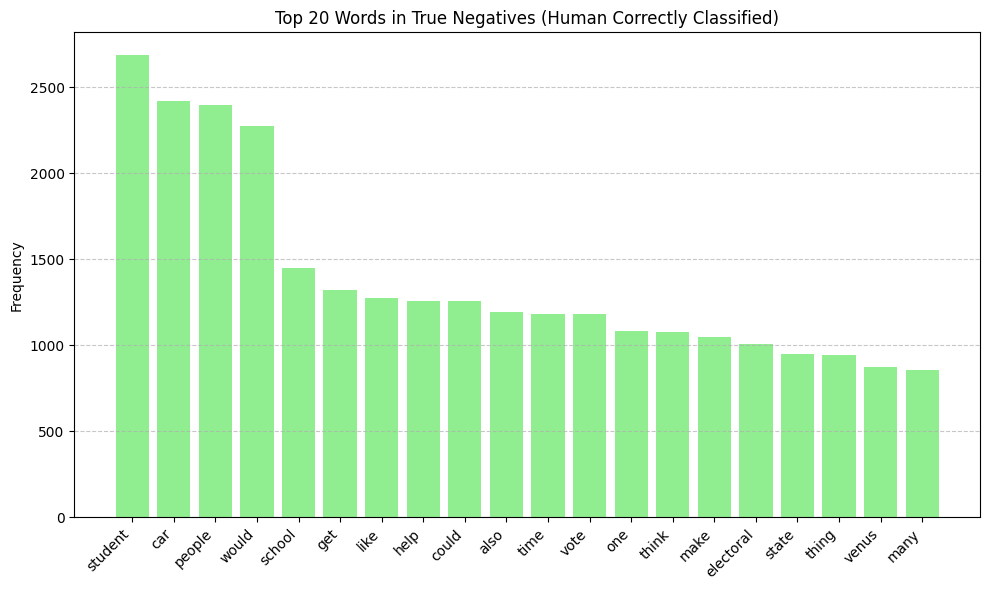

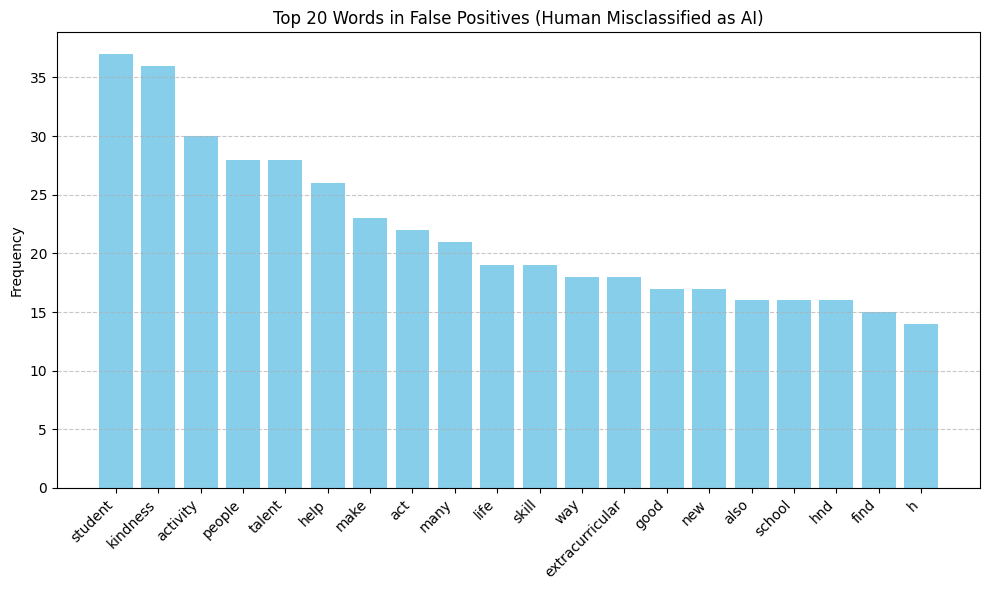

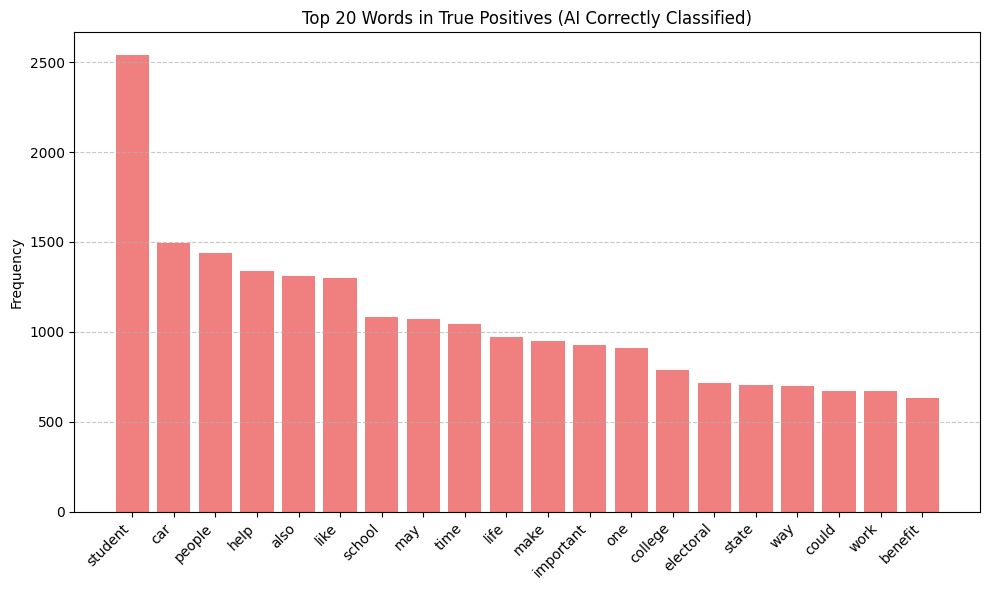

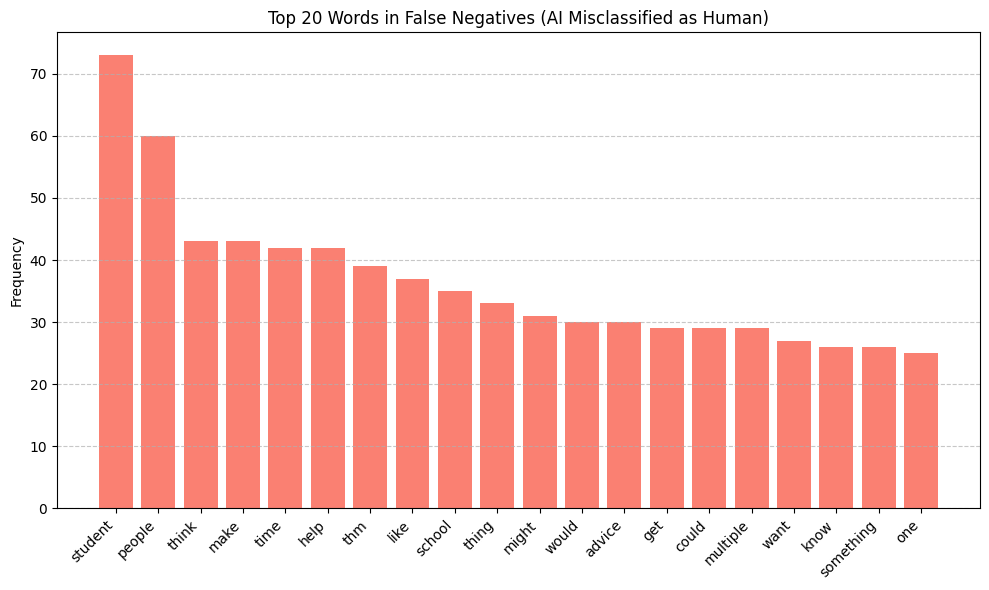

In [44]:
# Indices for True/False Positives/Negatives
fp_indices = (y_test == 0) & (y_pred_svm == 1)
fn_indices = (y_test == 1) & (y_pred_svm == 0)
tp_indices = (y_test == 1) & (y_pred_svm == 1)
tn_indices = (y_test == 0) & (y_pred_svm == 0)

# Extract the corresponding DataFrame rows
false_positives = df.loc[y_test.index[fp_indices]]
false_negatives = df.loc[y_test.index[fn_indices]]
true_positives = df.loc[y_test.index[tp_indices]]
true_negatives = df.loc[y_test.index[tn_indices]]

# Create word frequency counters
# False Positives (Human misclassified as AI)
fp_words = " ".join(false_positives['text']).split()
fp_freq = Counter(fp_words)

# True Negatives (correctly classified Human)
tn_words = " ".join(true_negatives['text']).split()
tn_freq = Counter(tn_words)

# False Negatives (AI misclassified as Human)
fn_words = " ".join(false_negatives['text']).split()
fn_freq = Counter(fn_words)

# True Positives (correctly classified AI)
tp_words = " ".join(true_positives['text']).split()
tp_freq = Counter(tp_words)

# Display Top 20 frequent words in each group
# Visualize as bar charts
def plot_top_words(freq_dict, title, color):
    top_words = dict(freq_dict.most_common(20))
    plt.figure(figsize=(10, 6))
    plt.bar(top_words.keys(), top_words.values(), color=color)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_top_words(tn_freq, "Top 20 Words in True Negatives (Human Correctly Classified)", 'lightgreen')
plot_top_words(fp_freq, "Top 20 Words in False Positives (Human Misclassified as AI)", 'skyblue')
plot_top_words(tp_freq, "Top 20 Words in True Positives (AI Correctly Classified)", 'lightcoral')
plot_top_words(fn_freq, "Top 20 Words in False Negatives (AI Misclassified as Human)", 'salmon')

# Sentiment Polarity Analysis

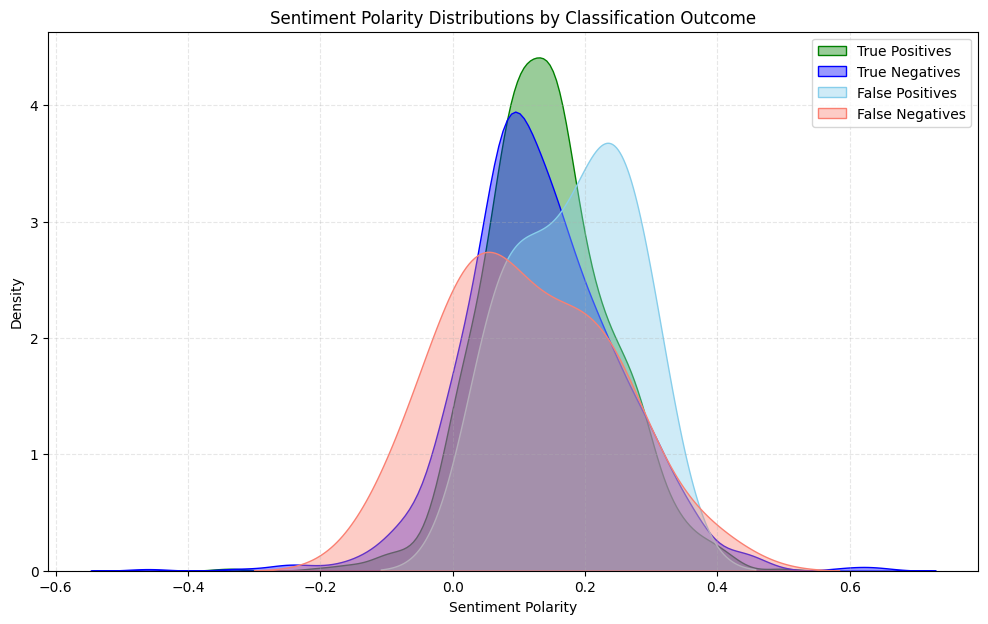

In [45]:
# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculate sentiment polarity for each group
tp_sentiments = true_positives['text'].apply(get_sentiment)
tn_sentiments = true_negatives['text'].apply(get_sentiment)
fp_sentiments = false_positives['text'].apply(get_sentiment)
fn_sentiments = false_negatives['text'].apply(get_sentiment)

# Plot all 4 sentiment distributions
plt.figure(figsize=(12, 7))
sns.kdeplot(tp_sentiments, label='True Positives', fill=True, color='green', alpha=0.4)
sns.kdeplot(tn_sentiments, label='True Negatives', fill=True, color='blue', alpha=0.4)
sns.kdeplot(fp_sentiments, label='False Positives', fill=True, color='skyblue', alpha=0.4)
sns.kdeplot(fn_sentiments, label='False Negatives', fill=True, color='salmon', alpha=0.4)
plt.title('Sentiment Polarity Distributions by Classification Outcome')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [46]:
# Basic statistics
print("True Positives - Sentiment Polarity:")
print(tp_sentiments.describe())
print("\nTrue Negatives - Sentiment Polarity:")
print(tn_sentiments.describe())
print("\nFalse Positives - Sentiment Polarity:")
print(fp_sentiments.describe())
print("\nFalse Negatives - Sentiment Polarity:")
print(fn_sentiments.describe())

True Positives - Sentiment Polarity:
count    978.000000
mean       0.141799
std        0.095478
min       -0.336585
25%        0.080195
50%        0.137391
75%        0.200485
max        0.496686
Name: text, dtype: float64

True Negatives - Sentiment Polarity:
count    988.000000
mean       0.134441
std        0.115587
min       -0.460000
25%        0.064769
50%        0.123196
75%        0.205489
max        0.642857
Name: text, dtype: float64

False Positives - Sentiment Polarity:
count    12.000000
mean      0.182400
std       0.087274
min       0.050599
25%       0.113015
50%       0.199448
75%       0.242098
max       0.297890
Name: text, dtype: float64

False Negatives - Sentiment Polarity:
count    22.000000
mean      0.113516
std       0.123735
min      -0.100058
25%       0.037043
50%       0.098440
75%       0.216862
max       0.384107
Name: text, dtype: float64


Overall, both human-written and AI-generated texts exhibit a slightly positive average sentiment. Among the correctly identified examples, sentiment polarity is relatively similar, with average scores around 0.14. Interestingly, the falsely identified human texts have a higher average sentiment polarity (0.18), suggesting that a more positive tone might contribute to misclassification. In contrast, the falsely identified AI texts show a slightly lower average sentiment polarity (0.11), which could indicate that more neutral texts are also prone to misclassification. Overall, these results highlight subtle differences in sentiment between correctly and incorrectly labeled texts.

# Average Sentence Length Analysis

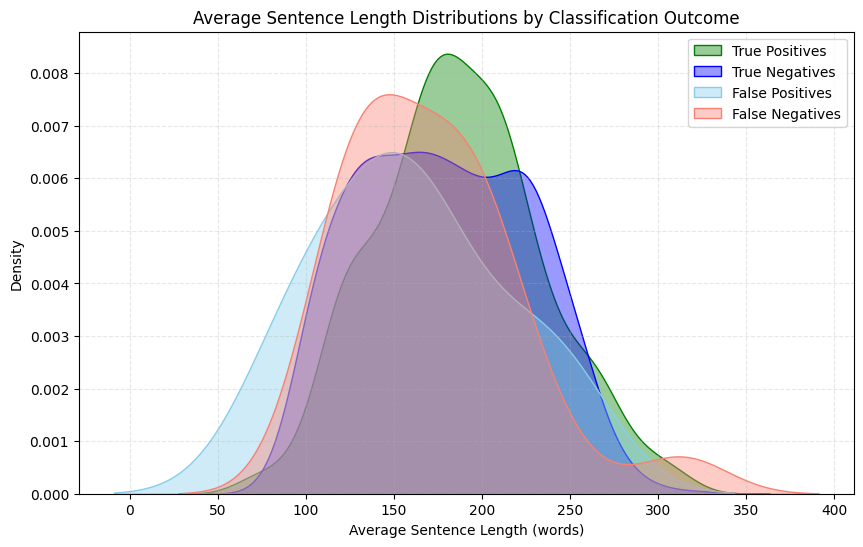

In [48]:
# Function to calculate average sentence length
def avg_sentence_length(text):
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0
    total_words = sum(len(sentence.split()) for sentence in sentences)
    return total_words / len(sentences)

# Calculate average sentence length for each group
tp_avg_lengths = true_positives['text'].apply(avg_sentence_length)
tn_avg_lengths = true_negatives['text'].apply(avg_sentence_length)
fp_avg_lengths = false_positives['text'].apply(avg_sentence_length)
fn_avg_lengths = false_negatives['text'].apply(avg_sentence_length)

# Plot all four distributions together
plt.figure(figsize=(10, 6))
sns.kdeplot(tp_avg_lengths, label='True Positives', fill=True, color='green', alpha=0.4)
sns.kdeplot(tn_avg_lengths, label='True Negatives', fill=True, color='blue', alpha=0.4)
sns.kdeplot(fp_avg_lengths, label='False Positives', fill=True, color='skyblue', alpha=0.4)
sns.kdeplot(fn_avg_lengths, label='False Negatives', fill=True, color='salmon', alpha=0.4)
plt.title('Average Sentence Length Distributions by Classification Outcome')
plt.xlabel('Average Sentence Length (words)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [49]:
# Print basic statistics
print("True Positives - Average Sentence Length:")
print(tp_avg_lengths.describe())
print("\nTrue Negatives - Average Sentence Length:")
print(tn_avg_lengths.describe())
print("\nFalse Positives - Average Sentence Length:")
print(fp_avg_lengths.describe())
print("\nFalse Negatives - Average Sentence Length:")
print(fn_avg_lengths.describe())

True Positives - Average Sentence Length:
count    978.000000
mean     186.696319
std       47.070852
min       63.000000
25%      155.000000
50%      185.000000
75%      216.000000
max      321.000000
Name: text, dtype: float64

True Negatives - Average Sentence Length:
count    988.000000
mean     178.147773
std       48.130063
min       81.000000
25%      138.750000
50%      177.000000
75%      218.000000
max      327.000000
Name: text, dtype: float64

False Positives - Average Sentence Length:
count     12.000000
mean     160.250000
std       53.095326
min       88.000000
25%      122.750000
50%      156.000000
75%      185.000000
max      246.000000
Name: text, dtype: float64

False Negatives - Average Sentence Length:
count     22.000000
mean     170.545455
std       48.248096
min      108.000000
25%      135.250000
50%      163.500000
75%      194.500000
max      313.000000
Name: text, dtype: float64


The analysis of average sentence length distributions by classification outcome reveals interesting patterns in how essay structure influences model performance. True Positives (correctly identified AI-generated essays) and True Negatives (correctly identified human-written essays) show average sentence lengths centered around 185 and 178 words, respectively, suggesting that typical sentence structures align well with accurate predictions. In contrast, False Positives (human essays misclassified as AI) have shorter average sentence lengths (≈160 words), indicating that essays with briefer sentences may be more prone to misclassification as AI-generated. False Negatives (AI essays misclassified as human) exhibit a mean around 170 words, a somewhat neutral zone that may blur distinctions for the model. These variations highlight that while sentence length provides some discriminatory power, it is not solely sufficient for precise classification.